# ***MLP***

In [ ]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_autotune_level=0"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"  
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"            
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# IMPORTS
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
import plotly.express as px

from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)

import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()
from model_evaluator import ModelEvaluator
me = ModelEvaluator([0,1,2])

import lime
import lime.lime_tabular

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)


/home/ssilvera/Escritorio/Proyectos/Modelo_pagos (copia)/venvmlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-19 09:26:11.550934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747664771.560164 1004294 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747664771.562957 1004294 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747664771.572242 1004294 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid lin

In [2]:
# LOAD DATA
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
# FILE PATHS
model_filename = "../Models/best_mlp_model.pkl"
study_filename = "../Study/optuna_study_MLP_nested.pkl"
metrics_filename = "../Models/best_mlp_metrics.pkl"
fold_metrics_filename = "./Metrics/mlp_folds_summary.csv"

In [4]:
# WRAPPER CLASS FOR MLP 
class MLPWrapper:
    def __init__(self, params, numeric_features, categorical_features):
        self.params = params.copy()
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.preprocessor = self._build_preprocessor()
        self.model = None

    def _build_preprocessor(self):
        return ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), self.numeric_features),
                ('cat', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first' ,sparse_output=False))
                ]), self.categorical_features)
            ],
            verbose_feature_names_out=False,
            remainder='passthrough'
        )

    def fit(self, X, y, eval_set=None, sample_weight=None):
        self.preprocessor = self._build_preprocessor().fit(X)
        X_proc = self.preprocessor.transform(X)
        y_cat = to_categorical(y)

        input_dim = X_proc.shape[1]
        num_classes = y_cat.shape[1]

        self.model = Sequential([
            Input(shape=(input_dim,)),
            Dense(self.params['units'], activation='relu'),
            Dropout(self.params['dropout']),
            Dense(num_classes, activation='softmax')
        ])

        self.model.compile(
            optimizer=self.params['optimizer'],
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        callbacks = []
        if self.params.get("early_stopping", True):
            callbacks.append(EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

        X_val_proc, y_val_cat = None, None
        if eval_set:
            X_val, y_val = eval_set[0]
            X_val_proc = self.preprocessor.transform(X_val)
            y_val_cat = to_categorical(y_val)

        self.history = self.model.fit(
            X_proc,
            y_cat,
            validation_data=(X_val_proc, y_val_cat) if eval_set else None,
            sample_weight=sample_weight,
            epochs=self.params['epochs'],
            batch_size=self.params['batch_size'],
            verbose=0,
            callbacks=callbacks
        )
        return self

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        y_proba = self.model.predict(X_proc)
        return np.argmax(y_proba, axis=1)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def save(self, path):
        self.model.save(f"{path}_model.h5")  # Save model separately
        joblib.dump({
            "params": self.params,
            "numeric_features": self.numeric_features,
            "categorical_features": self.categorical_features,
            "preprocessor": self.preprocessor,
        }, f"{path}_meta.pkl")

    @classmethod
    def load(cls, path):
        data = joblib.load(f"{path}_meta.pkl")
        wrapper = cls(data["params"], data["numeric_features"], data["categorical_features"])
        wrapper.preprocessor = data["preprocessor"]
        wrapper.model = load_model(f"{path}_model.h5")
        return wrapper


In [5]:
# OPTUNA INNER CV FOR MLP
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "units": trial.suggest_int("units", 64, 256, step=32),
            "dropout": trial.suggest_float("dropout", 0.1, 0.5),
            "optimizer": trial.suggest_categorical("optimizer", ["adam", "adamw", "rmsprop", "sgd"]),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
            "l2_reg": trial.suggest_float("l2_reg", 1e-6, 1e-3, log=True),
            "num_layers": trial.suggest_int("num_layers", 1, 2),
            "epochs": trial.suggest_int("epochs", 10, 70),
            "batch_size": trial.suggest_int("batch_size", 32, 256, log=True),
            "early_stopping": True,
            "patience": trial.suggest_int("patience", 5, 15)
        }

        model = MLPWrapper(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = []

        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            sample_weights = compute_sample_weight("balanced", y_t)

            model.fit(X_t, y_t, eval_set=[(X_v, y_v)], sample_weight=sample_weights)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))

        return np.mean(scores)

    pruner = MedianPruner()
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, n_jobs=10)

    return study.best_params, study

In [6]:
# NESTED CV
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y), 1), total=outer_cv.get_n_splits(), desc="Training folds"):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        best_params["num_classes"] = 3

        model = MLPWrapper(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = me.evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = me.evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = me.evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = me.save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig


    return best_model, best_metrics, study_dt, visualizations

In [ ]:
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [8]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3426
           1       0.76      0.70      0.73      1034
           2       0.75      0.65      0.70       625

    accuracy                           0.86      5085
   macro avg       0.81      0.77      0.79      5085
weighted avg       0.86      0.86      0.86      5085



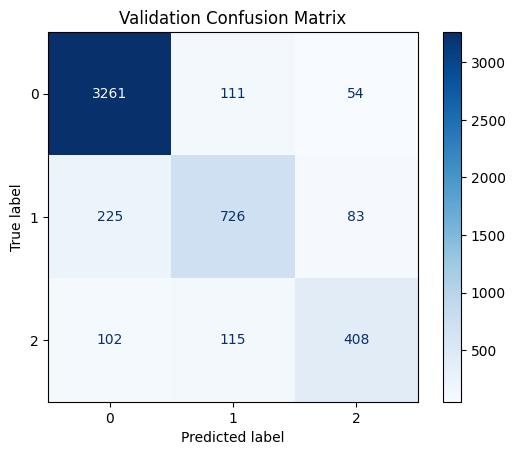

In [9]:
me.plot_confusion_matrix(metrics['confusion_matrix_val'], "Validation Confusion Matrix")

In [10]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4282
           1       0.75      0.71      0.73      1292
           2       0.78      0.64      0.70       781

    accuracy                           0.87      6355
   macro avg       0.81      0.77      0.79      6355
weighted avg       0.86      0.87      0.86      6355



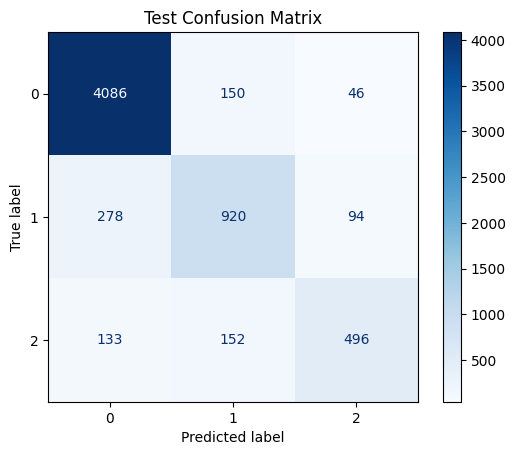

In [11]:
me.plot_confusion_matrix(metrics['confusion_matrix_test'],  "Test Confusion Matrix")

In [12]:
def plot_loss_curves_mlp(model):
    """
    Plots training and validation loss curves for Keras MLP model.
    """
    if not hasattr(model, "history") or model.history is None:
        raise ValueError("No training history available.")

    history = model.history.history  # Dict with loss, val_loss, etc.
    
    if "loss" in history:
        plt.plot(history["loss"], label="Train Loss")
    if "val_loss" in history:
        plt.plot(history["val_loss"], label="Val Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss - MLP")
    plt.legend()
    plt.grid(True)
    plt.show()


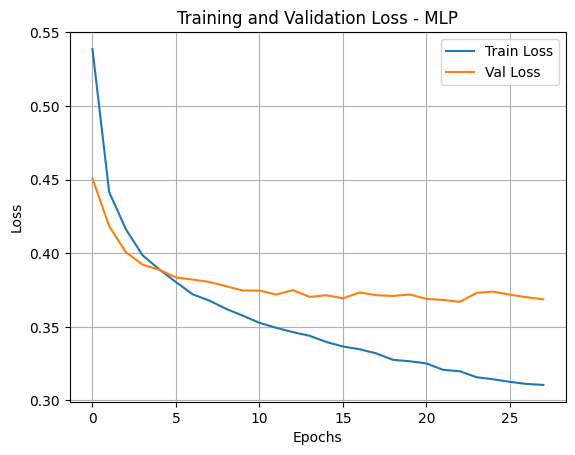

In [13]:
plot_loss_curves_mlp(model)

In [14]:
from lime.lime_tabular import LimeTabularExplainer
def get_lime_explainer(wrapper, X_train_raw, y_train_raw):
    # Apply preprocessing
    X_transformed = wrapper.preprocessor.transform(X_train_raw)
    
    # Get feature names after preprocessing
    feature_names = wrapper.preprocessor.get_feature_names_out()
    
    # Define class names as string labels
    class_names = [str(c) for c in sorted(set(y_train_raw))]

    explainer = LimeTabularExplainer(
        training_data=X_transformed,
        mode="classification",
        feature_names=feature_names,
        class_names=class_names,
        discretize_continuous=True,
        verbose=True
    )
    return explainer, X_transformed

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
Intercept 1.4488369112440858
Prediction_local [0.05873199]
Right: 0.1770685
Intercept -0.08276389518052674
Prediction_local [0.32617723]
Right: 0.5489423
Intercept -0.041105824216256553
Prediction_local [0.52656692]
Right: 0.27398914


--- Explanation for class 0 ---


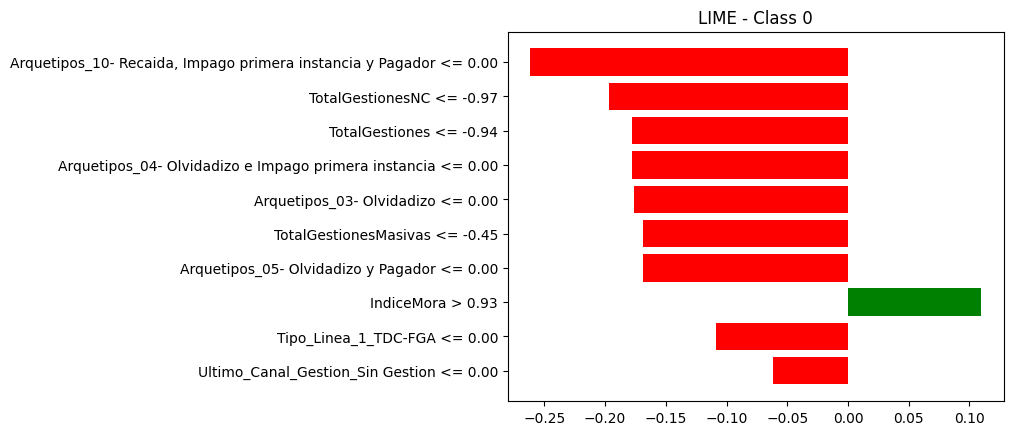

--- Explanation for class 1 ---


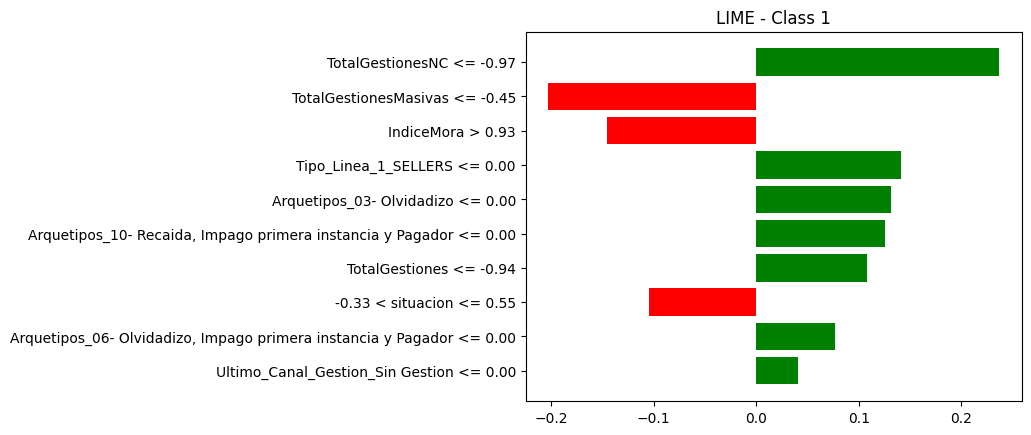

--- Explanation for class 2 ---


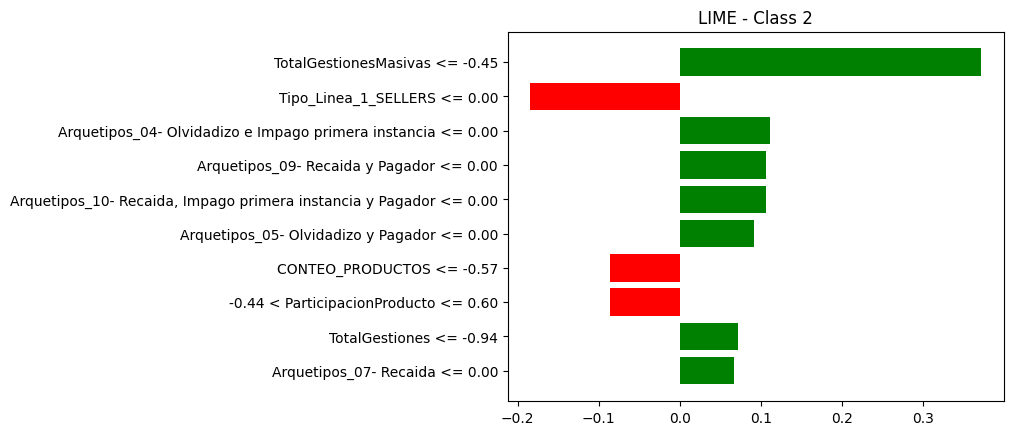

In [30]:
# Construir explainer
explainer, X_transformed = get_lime_explainer(model, metrics['X_train_fold'], metrics['y_train_fold'])
instance = X_transformed[185]

def predict_fn(x):
    return model.model.predict(x)

exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])
from IPython.display import display, HTML
display(HTML(exp.as_html(show_table=True)))

# Mostrar explicaciones para cada clase
for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [16]:
visualizations['optimization_history']

In [17]:
visualizations['parallel_coordinate']

In [18]:
visualizations['f1_score_evolution']

In [19]:
visualizations['param_importances']

In [20]:
reporte.save(metrics, model_name="MLP")


Report for model 'MLP' saved:
   → CSV: ./Metrics/Metrics_MLP.csv
   → JSON: ./Metrics/Metrics_MLP.json


In [21]:
df = reporte.load()


Loaded 8 report(s)


In [22]:
df.query("Model == 'MLP' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
24,MLP,val,0,0.909,0.952,0.93
25,MLP,val,1,0.763,0.702,0.731
26,MLP,val,2,0.749,0.653,0.697
27,MLP,val,macro avg,0.807,0.769,0.786
28,MLP,val,weighted avg,0.859,0.864,0.861


In [23]:
df.query("Model == 'MLP' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
30,MLP,test,0,0.909,0.954,0.931
31,MLP,test,1,0.753,0.712,0.732
32,MLP,test,2,0.78,0.635,0.7
33,MLP,test,macro avg,0.814,0.767,0.788
34,MLP,test,weighted avg,0.861,0.866,0.862


In [25]:
df.query("Model == 'MLP' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
29,MLP,val,0.864,0.367,0.95


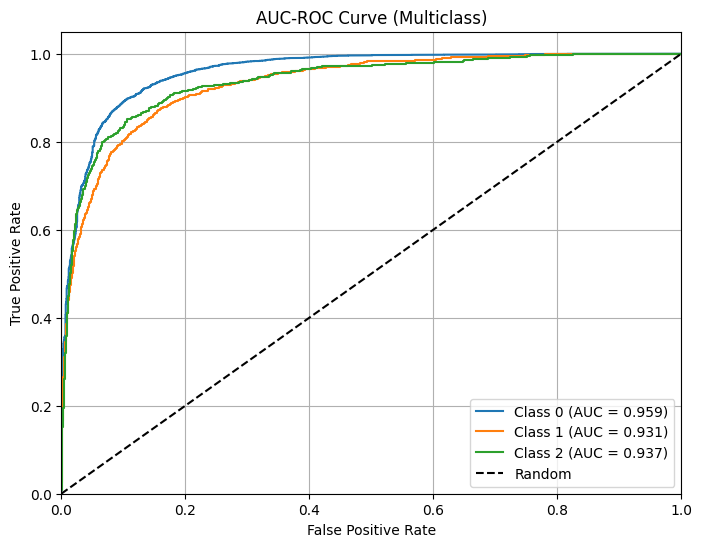

In [26]:
me.plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
)

In [27]:
model.params  

{'units': 224,
 'dropout': 0.12003798663185475,
 'optimizer': 'rmsprop',
 'learning_rate': 0.0006298962635888549,
 'l2_reg': 6.093714968802264e-05,
 'num_layers': 1,
 'epochs': 58,
 'batch_size': 229,
 'patience': 7,
 'num_classes': 3}